In [3]:
%matplotlib inline

1. Getting Started with Pre-trained TSN Models on UCF101
===========================================================

`UCF101 <https://www.crcv.ucf.edu/data/UCF101.php>`_  is an action recognition dataset
of realistic action videos, collected from YouTube. With 13,320 short trimmed videos
from 101 action categories, it is one of the most widely used dataset in the research
community for benchmarking state-of-the-art video action recognition models.

`TSN <https://arxiv.org/abs/1608.00859>`_ (Temporal Segment Network) is a widely adopted video
classification method. It is proposed to incorporate temporal information from an entire video.
The idea is straightforward: we can evenly divide the video into several segments,
process each segment individually, obtain segmental consensus from each segment, and perform
final prediction. TSN is more like a general algorithm, rather than a specific network architecture.
It can work with both 2D and 3D neural networks.

In this tutorial, we will demonstrate how to load a pre-trained TSN model from `gluoncv-model-zoo`
and classify video frames from the Internet or your local disk into one of the 101 action classes.

Step by Step
------------

We will show two exmaples here. For simplicity, we first try out a pre-trained UCF101 model
on a single video frame. This is actually an image action recognition problem.

First, please follow the `installation guide <../../index.html#installation>`__
to install ``MXNet`` and ``GluonCV`` if you haven't done so yet.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, image
from mxnet.gluon.data.vision import transforms
from gluoncv.data.transforms import video
from gluoncv import utils
from gluoncv.model_zoo import get_model

Then, we download and show the example image:



148KB [00:00, 149.03KB/s]                                                                                              


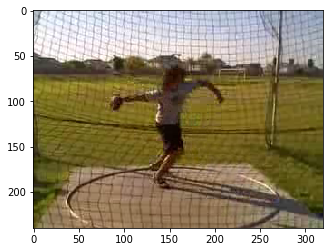

In [2]:
url = 'https://github.com/bryanyzhu/tiny-ucf101/raw/master/ThrowDiscus.png'
im_fname = utils.download(url)

img = image.imread(im_fname)

plt.imshow(img.asnumpy())
plt.show()

In case you don't recognize it, the image is a man throwing discus. :)

Now we define transformations for the image.



In [4]:
transform_fn = transforms.Compose([
    video.VideoCenterCrop(size=224),
    video.VideoToTensor(),
    video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

This transformation function does three things:
center crop the image to 224x224 in size,
transpose it to ``num_channels*height*width``,
and normalize with mean and standard deviation calculated across all ImageNet images.

What does the transformed image look like?



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


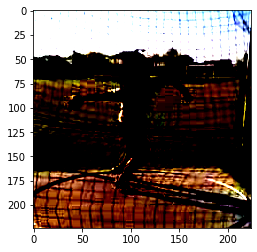

In [5]:
img_list = transform_fn([img.asnumpy()])
plt.imshow(np.transpose(img_list[0], (1,2,0)))
plt.show()

Can't recognize anything? *Don't panic!* Neither do I.
The transformation makes it more "model-friendly", instead of "human-friendly".

Next, we load a pre-trained VGG16 model. The VGG16 model is trained using TSN with three segments.



In [6]:
net = get_model('vgg16_ucf101', nclass=101, pretrained=True)

100%|████████████████████████████████████████████████████████████████████████| 500159/500159 [05:26<00:00, 1531.18KB/s]


486864KB [04:45, 1703.24KB/s]                                                                                          


Note that if you want to use InceptionV3 series model, please resize the image to have
both dimensions larger than 299 (e.g., 340x450) and change input size from 224 to 299
in the transform function. Finally, we prepare the image and feed it to the model.



In [7]:
pred = net(nd.array(img_list[0]).expand_dims(axis=0))

classes = net.classes
topK = 5
ind = nd.topk(pred, k=topK)[0].astype('int')
print('The input video frame is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (classes[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()))

The input video frame is classified to be
	[ThrowDiscus], with probability 0.998.
	[HorseRace], with probability 0.001.
	[VolleyballSpiking], with probability 0.001.
	[Hammering], with probability 0.000.
	[TennisSwing], with probability 0.000.


We can see that our pre-trained model predicts this video frame
to be ``throw discus`` action with high confidence.



The next example is how to perform video action recognition, e.g., use the same
pre-trained model on an entire video.



First, we download the video and sample the video frames at a speed of 1 frame per second.

.. raw:: html

    <div align="center">
        <img src="../../_static/action_basketball_demo.gif">
    </div>

    <br>



In [8]:
from gluoncv.utils import try_import_cv2
cv2 = try_import_cv2()

url = 'https://github.com/bryanyzhu/tiny-ucf101/raw/master/v_Basketball_g01_c01.avi'
video_fname = utils.download(url)

cap = cv2.VideoCapture(video_fname)
cnt = 0
video_frames = []
while(cap.isOpened()):
    ret, frame = cap.read()
    cnt += 1
    if ret and cnt % 25 == 0:
        video_frames.append(frame)
    if not ret: break

cap.release()
print('We evenly extract %d frames from the video %s.' % (len(video_frames), video_fname))

282KB [00:00, 776.39KB/s]                                                                                              


We evenly extract 5 frames from the video v_Basketball_g01_c01.avi.


Now we transform each video frame and feed them into the model.
In the end, we average the predictions from multiple video frames to get a reasonable prediction.



In [9]:
video_frames_transformed = transform_fn(video_frames)
final_pred = 0
for _, frame_img in enumerate(video_frames_transformed):
    pred = net(nd.array(frame_img).expand_dims(axis=0))
    final_pred += pred
final_pred /= len(video_frames)

classes = net.classes
topK = 5
ind = nd.topk(final_pred, k=topK)[0].astype('int')
print('The input video is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (classes[ind[i].asscalar()], nd.softmax(final_pred)[0][ind[i]].asscalar()))

The input video is classified to be
	[Basketball], with probability 0.978.
	[TennisSwing], with probability 0.020.
	[SoccerJuggling], with probability 0.002.
	[VolleyballSpiking], with probability 0.000.
	[JavelinThrow], with probability 0.000.


We can see that our pre-trained model predicts this video
to be ``basketball`` action with high confidence.
Note that, there are many ways to sample video frames and obtain a final video-level prediction.



Next Step
---------

If you would like to dive deeper into training TSN models on ``UCF101``,
feel free to read the next `tutorial on UCF101 <dive_deep_tsn_ucf101.html>`__.

